7275 - Project 2 Notebook - Group 3


Importing the required libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical tests
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

Loading the data

In [7]:
df = pd.read_csv('nvda_raw_data.csv')

# Initial inspection
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print("\nData types:")
print(df.head())
print(df.dtypes)
print("\nBasic statistics:")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())

Dataset Shape: (2514, 6)

First few rows:

Data types:
         Date Close/Last     Volume     Open      High        Low
0  12/05/2025    $182.41  143971100  $183.89   $184.66    $180.91
1  12/04/2025    $183.38  167364900  $181.62  $184.515    $179.96
2  12/03/2025    $179.59  165138000  $181.08   $182.45  $179.1101
3  12/02/2025    $181.46  182632200  $181.76   $185.66    $180.00
4  12/01/2025    $179.92  188131000  $174.76   $180.30    $173.68
Date          object
Close/Last    object
Volume         int64
Open          object
High          object
Low           object
dtype: object

Basic statistics:
             Volume
count  2.514000e+03
mean   4.585947e+08
std    2.560607e+08
min    5.244924e+07
25%    2.935183e+08
50%    4.101194e+08
75%    5.592553e+08
max    3.688132e+09

Missing values:
Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64


Data Preprocessing

In [8]:
def preprocess_nvda_data(df):
    """
    Preprocess NVIDIA stock data for time series analysis
    """
    # Create a copy
    df_clean = df.copy()
    
    # Parse date column - handle the MM/DD/YYYY format
    df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%m/%d/%Y')
    
    # Sort by date (ascending for time series)
    df_clean = df_clean.sort_values('Date')
    
    # Set date as index
    df_clean.set_index('Date', inplace=True)
    
    # Clean price columns (remove $ and convert to float)
    price_columns = ['Close/Last', 'Open', 'High', 'Low']
    for col in price_columns:
        if col in df_clean.columns:
            # Remove $ sign and convert to float
            df_clean[col] = df_clean[col].str.replace('$', '').str.replace(',', '').astype(float)
    
    # Ensure Volume is numeric
    df_clean['Volume'] = pd.to_numeric(df_clean['Volume'], errors='coerce')
    
    # Create additional features for analysis
    df_clean['Daily_Return'] = df_clean['Close/Last'].pct_change()
    df_clean['Log_Return'] = np.log(df_clean['Close/Last'] / df_clean['Close/Last'].shift(1))
    df_clean['Volatility'] = df_clean['Daily_Return'].rolling(window=20).std()
    
    # Moving averages
    df_clean['MA_5'] = df_clean['Close/Last'].rolling(window=5).mean()
    df_clean['MA_20'] = df_clean['Close/Last'].rolling(window=20).mean()
    df_clean['MA_50'] = df_clean['Close/Last'].rolling(window=50).mean()
    df_clean['MA_200'] = df_clean['Close/Last'].rolling(window=200).mean()
    
    # Volume moving average
    df_clean['Volume_MA'] = df_clean['Volume'].rolling(window=20).mean()
    
    # Price spreads
    df_clean['High_Low_Spread'] = df_clean['High'] - df_clean['Low']
    df_clean['High_Low_Pct'] = (df_clean['High'] - df_clean['Low']) / df_clean['Close/Last']
    df_clean['Open_Close_Spread'] = df_clean['Close/Last'] - df_clean['Open']
    
    # Technical indicators
    df_clean['RSI'] = calculate_rsi(df_clean['Close/Last'])
    df_clean['Upper_Band'], df_clean['Lower_Band'] = calculate_bollinger_bands(df_clean['Close/Last'])
    
    return df_clean

def calculate_rsi(prices, period=14):
    """Calculate Relative Strength Index"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(prices, period=20, num_std=2):
    """Calculate Bollinger Bands"""
    sma = prices.rolling(window=period).mean()
    std = prices.rolling(window=period).std()
    upper_band = sma + (std * num_std)
    lower_band = sma - (std * num_std)
    return upper_band, lower_band

# Process the data
df_clean = preprocess_nvda_data(df)

print("Preprocessed data shape:", df_clean.shape)
print("\nDate range:", df_clean.index.min(), "to", df_clean.index.max())
print("\nNumber of trading days:", len(df_clean))
print("\nNew features created:")
print(df_clean.columns.tolist())


Preprocessed data shape: (2514, 19)

Date range: 2015-12-08 00:00:00 to 2025-12-05 00:00:00

Number of trading days: 2514

New features created:
['Close/Last', 'Volume', 'Open', 'High', 'Low', 'Daily_Return', 'Log_Return', 'Volatility', 'MA_5', 'MA_20', 'MA_50', 'MA_200', 'Volume_MA', 'High_Low_Spread', 'High_Low_Pct', 'Open_Close_Spread', 'RSI', 'Upper_Band', 'Lower_Band']


In [9]:
df_clean

,Close/Last,Volume,Open,High,Low,Daily_Return,Log_Return,Volatility,MA_5,MA_20,MA_50,MA_200,Volume_MA,High_Low_Spread,High_Low_Pct,Open_Close_Spread,RSI,Upper_Band,Lower_Band
Date,,,,,,,,,,,,,,,,,,,
2015-12-08,0.8390,314481160,0.8175,0.8425,0.8123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0302,0.035995,0.0215,NaN,NaN,NaN
2015-12-09,0.8178,372674840,0.8388,0.8438,0.8093,-0.025268,-0.025593,NaN,NaN,NaN,NaN,NaN,NaN,0.0345,0.042186,-0.0210,NaN,NaN,NaN
2015-12-10,0.8245,236515080,0.8203,0.8290,0.8175,0.008193,0.008159,NaN,NaN,NaN,NaN,NaN,NaN,0.0115,0.013948,0.0042,NaN,NaN,NaN
2015-12-11,0.8123,227301520,0.8163,0.8220,0.8105,-0.014797,-0.014907,NaN,NaN,NaN,NaN,NaN,NaN,0.0115,0.014157,-0.0040,NaN,NaN,NaN
2015-12-14,0.8143,276209760,0.8130,0.8188,0.8045,0.002462,0.002459,NaN,0.82158,NaN,NaN,NaN,NaN,0.0143,0.017561,0.0013,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-01,179.9200,188131000,174.7600,180.3000,173.6800,0.016497,0.016363,0.026970,179.51000,187.5800,186.8948,153.89115,217413965.0,6.6200,0.036794,5.1600,32.737773,203.948809,171.211191
2025-12-02,181.4600,182632200,181.7600,185.6600,180.0000,0.008559,0.008523,0.026427,179.29200,186.3090,186.8518,154.10420,217532210.0,5.6600,0.031191,-0.3000,38.542891,200.114877,172.503123
2025-12-03,179.5900,165138000,181.0800,182.4500,179.1101,-0.010305,-0.010359,0.025266,179.64600,185.3540,186.8750,154.30515,216343145.0,3.3399,0.018597,-1.4900,36.412316,198.160050,172.547950


EDA - Visualizations

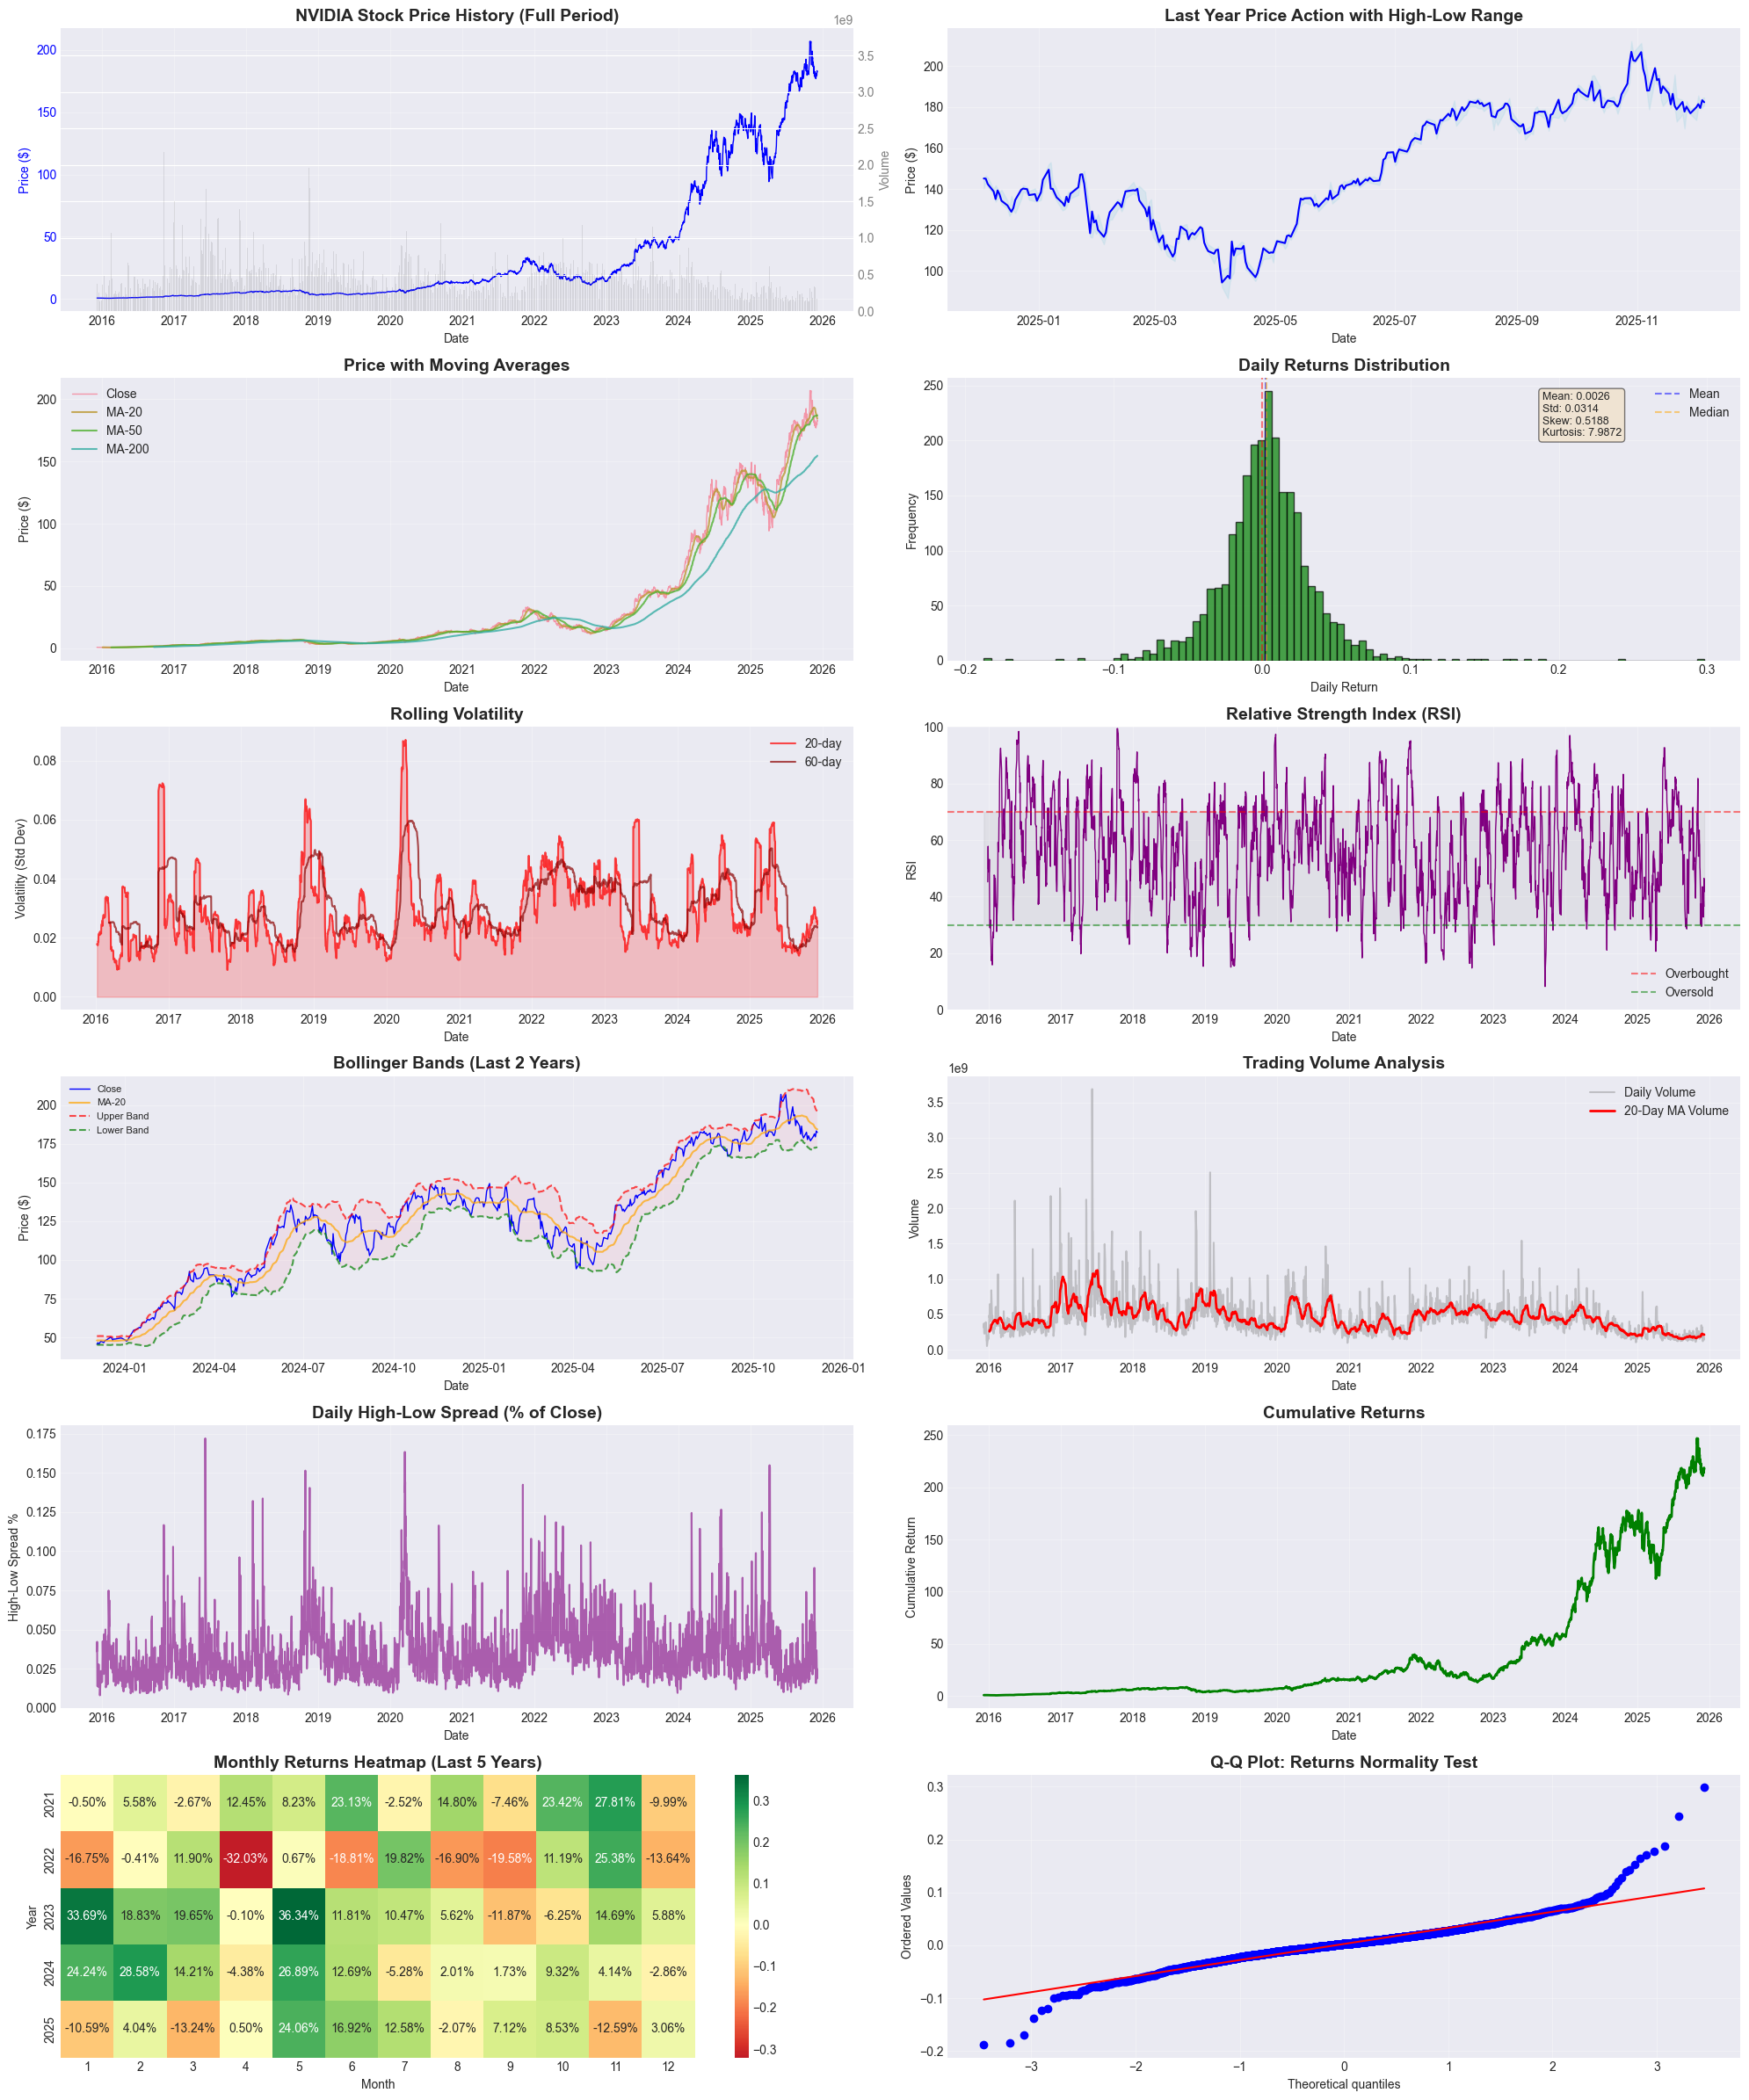


NVIDIA STOCK SUMMARY STATISTICS
Total Trading Days: 2514
Date Range: 2015-12-08 to 2025-12-05
Current Price: $182.41
52-Week High: $207.04
52-Week Low: $94.31
Average Daily Return: 0.2633%
Volatility (Annual): 49.8607%
Sharpe Ratio: 1.3306


In [10]:
fig = plt.figure(figsize=(20, 24))

# 1. Price history with volume
ax1 = plt.subplot(6, 2, 1)
ax1.plot(df_clean.index, df_clean['Close/Last'], label='Close Price', color='blue', linewidth=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price ($)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('NVIDIA Stock Price History (Full Period)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add volume on secondary axis
ax1_vol = ax1.twinx()
ax1_vol.bar(df_clean.index, df_clean['Volume'], alpha=0.2, color='gray', width=1)
ax1_vol.set_ylabel('Volume', color='gray')
ax1_vol.tick_params(axis='y', labelcolor='gray')

# 2. Recent price action (last year)
ax2 = plt.subplot(6, 2, 2)
recent_year = df_clean.iloc[-252:]  # Last trading year
ax2.plot(recent_year.index, recent_year['Close/Last'], label='Close', color='blue', linewidth=1.5)
ax2.fill_between(recent_year.index, recent_year['Low'], recent_year['High'], alpha=0.3, color='lightblue')
ax2.set_title('Last Year Price Action with High-Low Range', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price ($)')
ax2.grid(True, alpha=0.3)

# 3. Price with Moving Averages
ax3 = plt.subplot(6, 2, 3)
ax3.plot(df_clean.index, df_clean['Close/Last'], label='Close', alpha=0.7, linewidth=1)
ax3.plot(df_clean.index, df_clean['MA_20'], label='MA-20', alpha=0.8)
ax3.plot(df_clean.index, df_clean['MA_50'], label='MA-50', alpha=0.8)
ax3.plot(df_clean.index, df_clean['MA_200'], label='MA-200', alpha=0.8)
ax3.set_title('Price with Moving Averages', fontsize=14, fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('Price ($)')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# 4. Daily Returns Distribution
ax4 = plt.subplot(6, 2, 4)
returns = df_clean['Daily_Return'].dropna()
ax4.hist(returns, bins=100, edgecolor='black', alpha=0.7, color='green')
ax4.axvline(x=0, color='red', linestyle='--', alpha=0.5)
ax4.axvline(x=returns.mean(), color='blue', linestyle='--', alpha=0.5, label='Mean')
ax4.axvline(x=returns.median(), color='orange', linestyle='--', alpha=0.5, label='Median')
ax4.set_title('Daily Returns Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Daily Return')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Add statistics text
stats_text = f"Mean: {returns.mean():.4f}\nStd: {returns.std():.4f}\nSkew: {returns.skew():.4f}\nKurtosis: {returns.kurtosis():.4f}"
ax4.text(0.75, 0.95, stats_text, transform=ax4.transAxes, fontsize=9, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 5. Rolling Volatility (20-day and 60-day)
ax5 = plt.subplot(6, 2, 5)
ax5.plot(df_clean.index, df_clean['Volatility'], color='red', alpha=0.7, label='20-day')
ax5.plot(df_clean.index, df_clean['Daily_Return'].rolling(60).std(), color='darkred', alpha=0.7, label='60-day')
ax5.fill_between(df_clean.index, 0, df_clean['Volatility'], color='red', alpha=0.2)
ax5.set_title('Rolling Volatility', fontsize=14, fontweight='bold')
ax5.set_xlabel('Date')
ax5.set_ylabel('Volatility (Std Dev)')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. RSI Indicator
ax6 = plt.subplot(6, 2, 6)
ax6.plot(df_clean.index, df_clean['RSI'], color='purple', linewidth=1)
ax6.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Overbought')
ax6.axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Oversold')
ax6.fill_between(df_clean.index, 30, 70, alpha=0.1, color='gray')
ax6.set_title('Relative Strength Index (RSI)', fontsize=14, fontweight='bold')
ax6.set_xlabel('Date')
ax6.set_ylabel('RSI')
ax6.set_ylim(0, 100)
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Bollinger Bands
ax7 = plt.subplot(6, 2, 7)
recent_period = df_clean.iloc[-504:]  # Last 2 years
ax7.plot(recent_period.index, recent_period['Close/Last'], label='Close', color='blue', linewidth=1)
ax7.plot(recent_period.index, recent_period['MA_20'], label='MA-20', color='orange', alpha=0.7)
ax7.plot(recent_period.index, recent_period['Upper_Band'], label='Upper Band', color='red', linestyle='--', alpha=0.7)
ax7.plot(recent_period.index, recent_period['Lower_Band'], label='Lower Band', color='green', linestyle='--', alpha=0.7)
ax7.fill_between(recent_period.index, recent_period['Upper_Band'], recent_period['Lower_Band'], alpha=0.1)
ax7.set_title('Bollinger Bands (Last 2 Years)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Date')
ax7.set_ylabel('Price ($)')
ax7.legend(loc='best', fontsize=8)
ax7.grid(True, alpha=0.3)

# 8. Volume Analysis
ax8 = plt.subplot(6, 2, 8)
ax8.plot(df_clean.index, df_clean['Volume'], alpha=0.4, label='Daily Volume', color='gray')
ax8.plot(df_clean.index, df_clean['Volume_MA'], color='red', label='20-Day MA Volume', linewidth=2)
ax8.set_title('Trading Volume Analysis', fontsize=14, fontweight='bold')
ax8.set_xlabel('Date')
ax8.set_ylabel('Volume')
ax8.legend(loc='best')
ax8.grid(True, alpha=0.3)

# 9. High-Low Spread (Volatility Proxy)
ax9 = plt.subplot(6, 2, 9)
ax9.plot(df_clean.index, df_clean['High_Low_Pct'], color='purple', alpha=0.6)
ax9.set_title('Daily High-Low Spread (% of Close)', fontsize=14, fontweight='bold')
ax9.set_xlabel('Date')
ax9.set_ylabel('High-Low Spread %')
ax9.grid(True, alpha=0.3)

# 10. Cumulative Returns
ax10 = plt.subplot(6, 2, 10)
cumulative_returns = (1 + df_clean['Daily_Return']).cumprod()
ax10.plot(df_clean.index, cumulative_returns, color='green', linewidth=2)
ax10.set_title('Cumulative Returns', fontsize=14, fontweight='bold')
ax10.set_xlabel('Date')
ax10.set_ylabel('Cumulative Return')
ax10.grid(True, alpha=0.3)

# 11. Monthly Returns Heatmap Data Prep
ax11 = plt.subplot(6, 2, 11)
df_clean['Year'] = df_clean.index.year
df_clean['Month'] = df_clean.index.month
monthly_returns = df_clean.groupby(['Year', 'Month'])['Daily_Return'].apply(lambda x: (1 + x).prod() - 1)
monthly_returns_pivot = monthly_returns.unstack()
sns.heatmap(monthly_returns_pivot.iloc[-5:], annot=True, fmt='.2%', cmap='RdYlGn', center=0, ax=ax11)
ax11.set_title('Monthly Returns Heatmap (Last 5 Years)', fontsize=14, fontweight='bold')

# 12. Q-Q Plot for Returns Normality
from scipy import stats
ax12 = plt.subplot(6, 2, 12)
stats.probplot(returns, dist="norm", plot=ax12)
ax12.set_title('Q-Q Plot: Returns Normality Test', fontsize=14, fontweight='bold')
ax12.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("NVIDIA STOCK SUMMARY STATISTICS")
print("="*60)
print(f"Total Trading Days: {len(df_clean)}")
print(f"Date Range: {df_clean.index.min().date()} to {df_clean.index.max().date()}")
print(f"Current Price: ${df_clean['Close/Last'].iloc[-1]:.2f}")
print(f"52-Week High: ${df_clean['Close/Last'].iloc[-252:].max():.2f}")
print(f"52-Week Low: ${df_clean['Close/Last'].iloc[-252:].min():.2f}")
print(f"Average Daily Return: {df_clean['Daily_Return'].mean():.4%}")
print(f"Volatility (Annual): {df_clean['Daily_Return'].std() * np.sqrt(252):.4%}")
print(f"Sharpe Ratio: {(df_clean['Daily_Return'].mean() / df_clean['Daily_Return'].std()) * np.sqrt(252):.4f}")

In [36]:
#Check if df_clean exists
try:
    df_clean
    print("✅ df_clean found!")
except NameError:
    print("❌ ERROR: df_clean not found!")
    print("Please run your preprocessing code first:")
    print("   df_clean = preprocess_nvda_data(df)")
    raise


from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Target series
y = df_clean['Close/Last'].copy()

# Time-based splits
train = y.loc[:'2022-12-31']
val = y.loc['2023-01-01':'2023-12-31']
test = y.loc['2024-01-01':]
train_val = pd.concat([train, val])

# Evaluation functions
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100/len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

def evaluate_forecast(y_true, y_pred, model_name="Model"):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    min_len = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:min_len], y_pred[:min_len]
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape_val = mape(y_true, y_pred)
    smape_val = smape(y_true, y_pred)
    
    return {"model": model_name, "MAE": round(mae, 4), "RMSE": round(rmse, 4), 
            "MAPE": round(mape_val, 2), "sMAPE": round(smape_val, 2)}

# Initialize results
results = []
test_results = []

print("\n" + "="*70)
print("SETUP COMPLETE")
print("="*70)
print(f"Train: {train.index.min().date()} → {train.index.max().date()} ({len(train)} days)")
print(f"Val:   {val.index.min().date()} → {val.index.max().date()} ({len(val)} days)")
print(f"Test:  {test.index.min().date()} → {test.index.max().date()} ({len(test)} days)")



✅ df_clean found!

SETUP COMPLETE
Train: 2015-12-08 → 2022-12-30 (1779 days)
Val:   2023-01-03 → 2023-12-29 (250 days)
Test:  2024-01-02 → 2025-12-05 (485 days)



ACF/PACF ANALYSIS


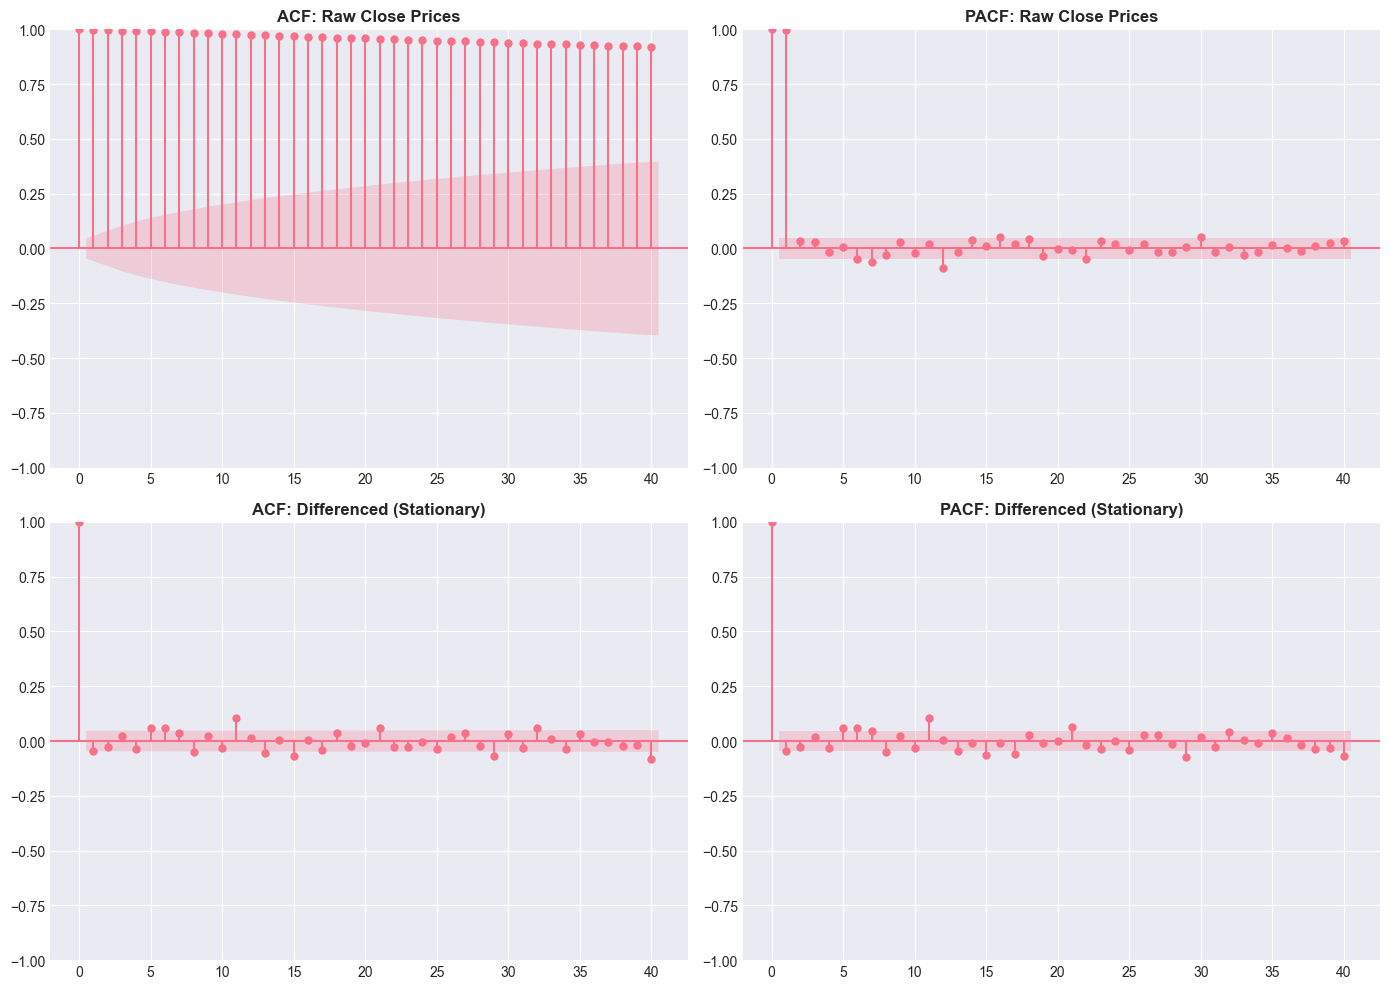

📌 Raw prices: Slow ACF decay → Non-stationary
📌 Differenced: Quick decay → Stationary (d=1)
📌 PACF cuts at lag 2 → AR(2), ACF cuts at lag 2 → MA(2)


In [37]:
# ACF/PACF PLOTS

print("\n" + "="*70)
print("ACF/PACF ANALYSIS")
print("="*70)

train_diff = train.diff().dropna()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

plot_acf(train, lags=40, ax=axes[0, 0])
axes[0, 0].set_title('ACF: Raw Close Prices', fontweight='bold')

plot_pacf(train, lags=40, ax=axes[0, 1])
axes[0, 1].set_title('PACF: Raw Close Prices', fontweight='bold')

plot_acf(train_diff, lags=40, ax=axes[1, 0])
axes[1, 0].set_title('ACF: Differenced (Stationary)', fontweight='bold')

plot_pacf(train_diff, lags=40, ax=axes[1, 1])
axes[1, 1].set_title('PACF: Differenced (Stationary)', fontweight='bold')

plt.tight_layout()
plt.savefig('08_acf_pacf.png', dpi=150)
plt.show()

print("📌 Raw prices: Slow ACF decay → Non-stationary")
print("📌 Differenced: Quick decay → Stationary (d=1)")
print("📌 PACF cuts at lag 2 → AR(2), ACF cuts at lag 2 → MA(2)")

In [38]:
# PART 9: STATIONARITY TESTS
print("\n" + "="*70)
print("STATIONARITY TESTS (ADF & KPSS)")
print("="*70)

def stationarity_test(series, name):
    print(f"\n─── {name} ───")
    adf = adfuller(series.dropna(), autolag='AIC')
    kpss_res = kpss(series.dropna(), regression='c', nlags='auto')
    print(f"ADF:  stat={adf[0]:.4f}, p-value={adf[1]:.6f}")
    print(f"KPSS: stat={kpss_res[0]:.4f}, p-value={kpss_res[1]:.4f}")
    if adf[1] <= 0.05 and kpss_res[1] >= 0.05:
        print("→ ✅ STATIONARY")
    elif adf[1] > 0.05 and kpss_res[1] < 0.05:
        print("→ ❌ NON-STATIONARY")
    else:
        print("→ ⚠️ MIXED RESULTS")

stationarity_test(train, "Raw Prices")
stationarity_test(train.diff().dropna(), "First Difference (d=1)")
stationarity_test(train.pct_change().dropna(), "Daily Returns")


STATIONARITY TESTS (ADF & KPSS)

─── Raw Prices ───
ADF:  stat=-1.3298, p-value=0.615423
KPSS: stat=4.9331, p-value=0.0100
→ ❌ NON-STATIONARY

─── First Difference (d=1) ───
ADF:  stat=-8.7821, p-value=0.000000
KPSS: stat=0.0881, p-value=0.1000
→ ✅ STATIONARY

─── Daily Returns ───
ADF:  stat=-15.2931, p-value=0.000000
KPSS: stat=0.2376, p-value=0.1000
→ ✅ STATIONARY


C:\Users\vonha\AppData\Local\Temp\ipykernel_18044\3570086480.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags='auto')
C:\Users\vonha\AppData\Local\Temp\ipykernel_18044\3570086480.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags='auto')
C:\Users\vonha\AppData\Local\Temp\ipykernel_18044\3570086480.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags='auto')



SEASONAL DECOMPOSITION


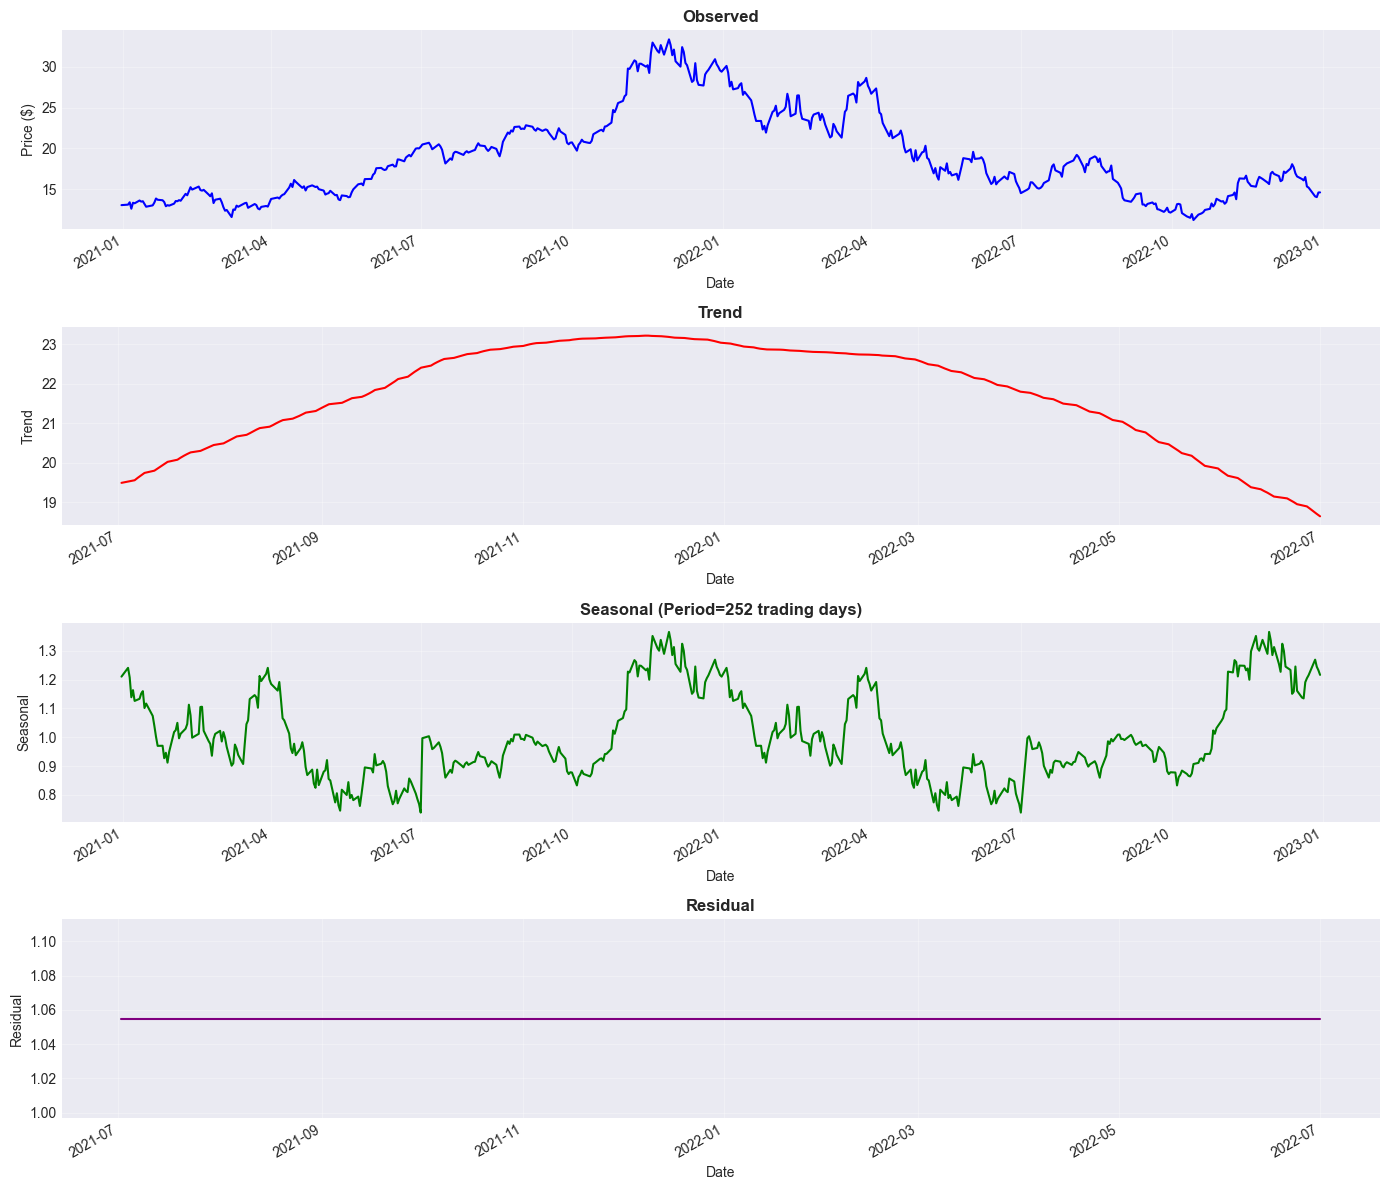

📌 Trend: Strong upward trend dominates
📌 Seasonal: Weak annual seasonality (~1-2%)
📌 Residual: Random noise component


In [39]:
# SEASONAL DECOMPOSITION

print("\n" + "="*70)
print("SEASONAL DECOMPOSITION")
print("="*70)

decomp = seasonal_decompose(train.iloc[-504:], model='multiplicative', period=252)

fig, axes = plt.subplots(4, 1, figsize=(14, 12))
decomp.observed.plot(ax=axes[0], color='blue')
axes[0].set_title('Observed', fontweight='bold')
axes[0].set_ylabel('Price ($)')

decomp.trend.plot(ax=axes[1], color='red')
axes[1].set_title('Trend', fontweight='bold')
axes[1].set_ylabel('Trend')

decomp.seasonal.plot(ax=axes[2], color='green')
axes[2].set_title('Seasonal (Period=252 trading days)', fontweight='bold')
axes[2].set_ylabel('Seasonal')

decomp.resid.plot(ax=axes[3], color='purple')
axes[3].set_title('Residual', fontweight='bold')
axes[3].set_ylabel('Residual')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('10_decomposition.png', dpi=150)
plt.show()

print("📌 Trend: Strong upward trend dominates")
print("📌 Seasonal: Weak annual seasonality (~1-2%)")
print("📌 Residual: Random noise component")


TRAIN/VALIDATION/TEST SPLIT


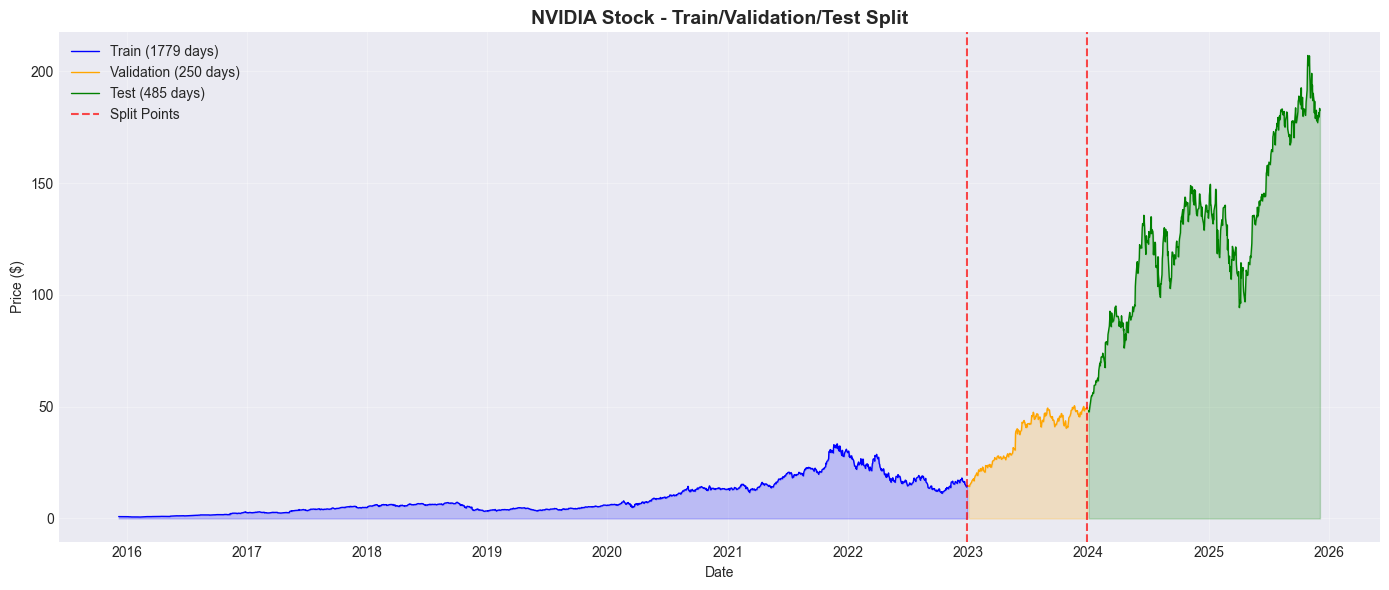

📊 Train: 1779 days (70.8%)
📊 Val:   250 days (9.9%)
📊 Test:  485 days (19.3%)


In [40]:
# DATA SPLIT VISUALIZATION
print("\n" + "="*70)
print("TRAIN/VALIDATION/TEST SPLIT")
print("="*70)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(train.index, train, label=f'Train ({len(train)} days)', color='blue', linewidth=1)
ax.plot(val.index, val, label=f'Validation ({len(val)} days)', color='orange', linewidth=1)
ax.plot(test.index, test, label=f'Test ({len(test)} days)', color='green', linewidth=1)
ax.axvline(train.index.max(), color='red', linestyle='--', alpha=0.7, label='Split Points')
ax.axvline(val.index.max(), color='red', linestyle='--', alpha=0.7)
ax.fill_between(train.index, train, alpha=0.2, color='blue')
ax.fill_between(val.index, val, alpha=0.2, color='orange')
ax.fill_between(test.index, test, alpha=0.2, color='green')
ax.set_title('NVIDIA Stock - Train/Validation/Test Split', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('11_split.png', dpi=150)
plt.show()

print(f"📊 Train: {len(train)} days ({len(train)/len(y)*100:.1f}%)")
print(f"📊 Val:   {len(val)} days ({len(val)/len(y)*100:.1f}%)")
print(f"📊 Test:  {len(test)} days ({len(test)/len(y)*100:.1f}%)")

In [41]:
# BASELINE MODELS
print("\n" + "="*70)
print("BASELINE MODELS")
print("="*70)

full_series = pd.concat([train, val, test])

# Naive Forecast
print("\n📈 Baseline 1: Naive Forecast")
naive_test = full_series.shift(1).loc[test.index]
test_results.append(evaluate_forecast(test, naive_test, "Naive"))

# Simple Moving Average
print("📈 Baseline 2: Simple Moving Average (SMA)")
for w in [5, 20, 50]:
    sma = full_series.rolling(w).mean().shift(1).loc[test.index]
    test_results.append(evaluate_forecast(test, sma, f"SMA-{w}"))

# Exponential Moving Average
print("📈 Baseline 3: Exponential Moving Average (EMA)")
for s in [5, 20]:
    ema = full_series.ewm(span=s).mean().shift(1).loc[test.index]
    test_results.append(evaluate_forecast(test, ema, f"EMA-{s}"))

# Drift Model
print("📈 Baseline 4: Drift Model")
y1, yT, T = train_val.iloc[0], train_val.iloc[-1], len(train_val)
drift_pred = [yT + (yT - y1)/(T-1) * h for h in range(1, len(test)+1)]
drift_test = pd.Series(drift_pred, index=test.index)
test_results.append(evaluate_forecast(test, drift_test, "Drift"))

print("\n📊 Baseline Results (Test Set):")
baseline_df = pd.DataFrame(test_results)
print(baseline_df.to_string(index=False))



BASELINE MODELS

📈 Baseline 1: Naive Forecast
📈 Baseline 2: Simple Moving Average (SMA)
📈 Baseline 3: Exponential Moving Average (EMA)
📈 Baseline 4: Drift Model

📊 Baseline Results (Test Set):
 model     MAE    RMSE  MAPE  sMAPE
 Naive  2.8993  3.9314  2.35   2.35
 SMA-5  4.2880  5.5367  3.52   3.54
SMA-20  7.6029  9.2584  6.36   6.49
SMA-50 12.4003 15.0887 10.32  10.91
 EMA-5  3.8557  4.9654  3.18   3.19
EMA-20  6.9017  8.3569  5.76   5.87
 Drift 73.6220 80.6103 53.74  75.46



SARIMA MODEL
🔍 Grid searching SARIMA parameters...


C:\Users\vonha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\vonha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\vonha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimi


✅ Best SARIMA: (2, 1, 1)×(0, 0, 1, 21)
   AIC: 1772.37


C:\Users\vonha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\vonha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



🔄 Running rolling 1-step forecast...


C:\Users\vonha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   Processed 100/485 days...


C:\Users\vonha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\vonha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   Processed 200/485 days...
   Processed 300/485 days...
   Processed 400/485 days...

📊 SARIMA Residual Diagnostics:


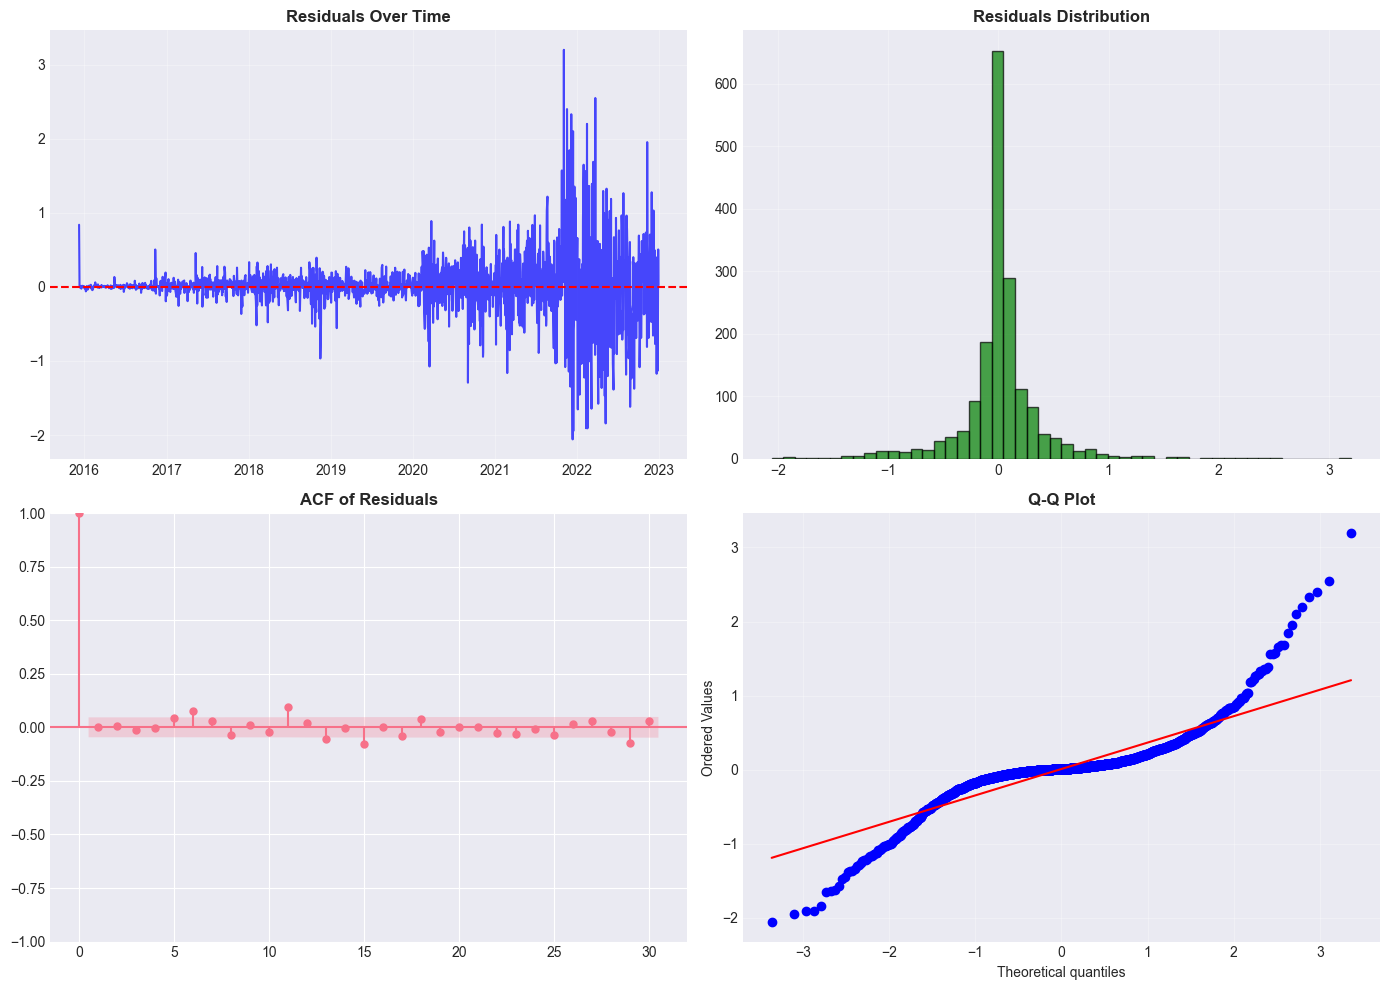


📊 Ljung-Box Test:
      lb_stat  lb_pvalue
10  18.885213   0.041745
20  58.277350   0.000013


In [42]:
# SARIMA MODEL
print("\n" + "="*70)
print("SARIMA MODEL")
print("="*70)
print("🔍 Grid searching SARIMA parameters...")
best_aic = np.inf
best_order = None
best_seasonal = None
best_model = None

for p in range(3):
    for q in range(3):
        for P in range(2):
            for Q in range(2):
                for s in [5, 21]:
                    try:
                        model = SARIMAX(train, order=(p, 1, q),
                                       seasonal_order=(P, 0, Q, s),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False)
                        fit = model.fit(disp=False, maxiter=100)
                        if fit.aic < best_aic:
                            best_aic = fit.aic
                            best_order = (p, 1, q)
                            best_seasonal = (P, 0, Q, s)
                            best_model = fit
                    except:
                        continue

print(f"\n✅ Best SARIMA: {best_order}×{best_seasonal}")
print(f"   AIC: {best_aic:.2f}")

# Retrain on train+val
sarima_final = SARIMAX(train_val, order=best_order, seasonal_order=best_seasonal,
                       enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

# Rolling 1-step forecast for fair comparison
print("\n🔄 Running rolling 1-step forecast...")
history = train_val.values.tolist()
sarima_predictions = []

for t in range(len(test)):
    model = SARIMAX(history, order=best_order, seasonal_order=best_seasonal,
                    enforce_stationarity=False, enforce_invertibility=False)
    fit = model.fit(disp=False)
    pred = fit.forecast(steps=1)[0]
    sarima_predictions.append(pred)
    history.append(test.iloc[t])
    
    if (t + 1) % 100 == 0:
        print(f"   Processed {t+1}/{len(test)} days...")

sarima_test = pd.Series(sarima_predictions, index=test.index)
test_results.append(evaluate_forecast(test, sarima_test, "SARIMA (Rolling)"))

# Residual diagnostics
print("\n📊 SARIMA Residual Diagnostics:")
resid = best_model.resid

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(resid, color='blue', alpha=0.7)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title('Residuals Over Time', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(resid.dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Residuals Distribution', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

plot_acf(resid.dropna(), lags=30, ax=axes[1, 0])
axes[1, 0].set_title('ACF of Residuals', fontweight='bold')

stats.probplot(resid.dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('14_sarima_diagnostics.png', dpi=150)
plt.show()

# Ljung-Box test
lb = acorr_ljungbox(resid.dropna(), lags=[10, 20], return_df=True)
print("\n📊 Ljung-Box Test:")
print(lb)


LSTM NEURAL NETWORK
🔍 Testing window sizes...
   Window=20: Val Loss=0.001977
   Window=30: Val Loss=0.004143
   Window=60: Val Loss=0.005252

✅ Best window: 20 days


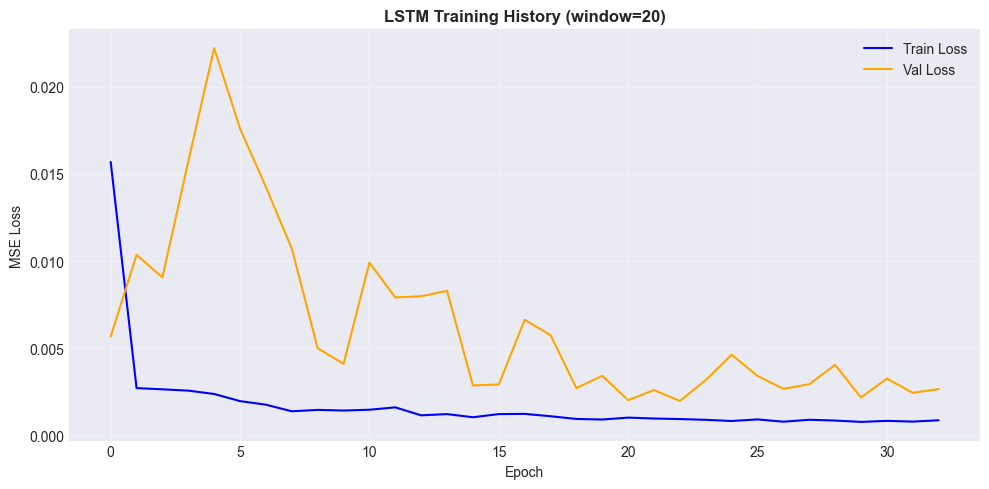


🔄 Running LSTM rolling 1-step forecast...
   Processed 100/485 days...
   Processed 200/485 days...
   Processed 300/485 days...
   Processed 400/485 days...


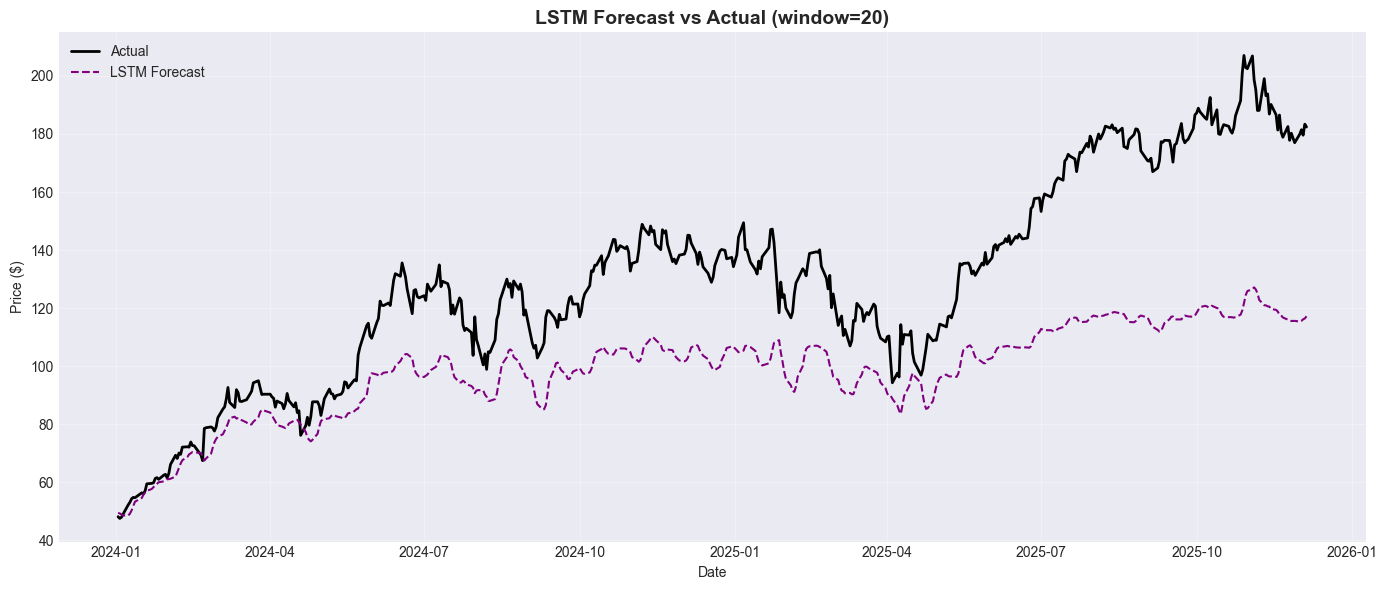

In [43]:
# LSTM MODEL
print("\n" + "="*70)
print("LSTM NEURAL NETWORK")
print("="*70)

# Prepare data
series = df_clean['Close/Last'].astype(float)
train_s = series.loc[train.index]
val_s = series.loc[val.index]
test_s = series.loc[test.index]

scaler = MinMaxScaler()
train_sc = scaler.fit_transform(train_s.values.reshape(-1, 1))
val_sc = scaler.transform(val_s.values.reshape(-1, 1))
test_sc = scaler.transform(test_s.values.reshape(-1, 1))

def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)

print("🔍 Testing window sizes...")
best_loss = np.inf
best_window = None
best_lstm = None
best_history = None

for w in [20, 30, 60]:
    X_train, y_train = create_sequences(train_sc, w)
    X_val, y_val = create_sequences(np.concatenate([train_sc[-w:], val_sc]), w)
    
    tf.random.set_seed(42)
    np.random.seed(42)
    
    model = models.Sequential([
        layers.Input(shape=(w, 1)),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, 
                                          restore_best_weights=True)
    
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)
    
    val_loss = min(history.history['val_loss'])
    print(f"   Window={w}: Val Loss={val_loss:.6f}")
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_window = w
        best_lstm = model
        best_history = history

print(f"\n✅ Best window: {best_window} days")

# Plot training history
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(best_history.history['loss'], label='Train Loss', color='blue')
ax.plot(best_history.history['val_loss'], label='Val Loss', color='orange')
ax.set_title(f'LSTM Training History (window={best_window})', fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('15_lstm_training.png', dpi=150)
plt.show()

# Rolling 1-step forecast for LSTM
print("\n🔄 Running LSTM rolling 1-step forecast...")
combined_sc = np.concatenate([train_sc, val_sc, test_sc])
lstm_predictions = []

for t in range(len(test)):
    # Get the last 'best_window' values before this point
    start_idx = len(train_sc) + len(val_sc) + t - best_window
    X_input = combined_sc[start_idx:start_idx + best_window].reshape(1, best_window, 1)
    pred_sc = best_lstm.predict(X_input, verbose=0)[0, 0]
    lstm_predictions.append(pred_sc)
    
    if (t + 1) % 100 == 0:
        print(f"   Processed {t+1}/{len(test)} days...")

# Inverse transform predictions
lstm_pred = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1)).flatten()
test_results.append(evaluate_forecast(test.values, lstm_pred, f"LSTM (w={best_window})"))

# Plot LSTM forecast
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(test.index, test.values, label='Actual', color='black', linewidth=2)
ax.plot(test.index, lstm_pred, label='LSTM Forecast', color='purple', linestyle='--', linewidth=1.5)
ax.set_title(f'LSTM Forecast vs Actual (window={best_window})', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('15_lstm_forecast.png', dpi=150)
plt.show()


In [44]:
# EVALUATION SUMMARY
print("\n" + "="*70)
print("EVALUATION SUMMARY")
print("="*70)

test_df = pd.DataFrame(test_results)
print("\n📊 ALL MODELS - TEST SET RESULTS:")
print(test_df.to_string(index=False))
# Find best model
best_idx = test_df['RMSE'].idxmin()
print(f"\n🏆 Best Model by RMSE: {test_df.loc[best_idx, 'model']}")
print(f"   MAE:  ${test_df.loc[best_idx, 'MAE']:.4f}")
print(f"   RMSE: ${test_df.loc[best_idx, 'RMSE']:.4f}")
print(f"   MAPE: {test_df.loc[best_idx, 'MAPE']:.2f}%")


EVALUATION SUMMARY

📊 ALL MODELS - TEST SET RESULTS:
           model     MAE    RMSE  MAPE  sMAPE
           Naive  2.8993  3.9314  2.35   2.35
           SMA-5  4.2880  5.5367  3.52   3.54
          SMA-20  7.6029  9.2584  6.36   6.49
          SMA-50 12.4003 15.0887 10.32  10.91
           EMA-5  3.8557  4.9654  3.18   3.19
          EMA-20  6.9017  8.3569  5.76   5.87
           Drift 73.6220 80.6103 53.74  75.46
SARIMA (Rolling)  2.9136  3.9497  2.37   2.37
     LSTM (w=20) 30.8729 37.0987 21.25  24.48

🏆 Best Model by RMSE: Naive
   MAE:  $2.8993
   RMSE: $3.9314
   MAPE: 2.35%



SHORT-TERM vs LONG-TERM FORECASTING

📊 Forecast Performance by Horizon:
Horizon  SARIMA_RMSE  SARIMA_MAPE%  Naive_RMSE  Naive_MAPE%
  1-day         1.28          2.66        1.35         2.81
  5-day         1.76          3.13        1.77         3.24
 10-day         3.96          6.33        3.93         6.32
 20-day         8.13         11.92        8.14        11.94
 60-day        26.71         28.85       26.74        28.89
120-day        41.62         38.83       41.66        38.88


C:\Users\vonha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\vonha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\vonha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C

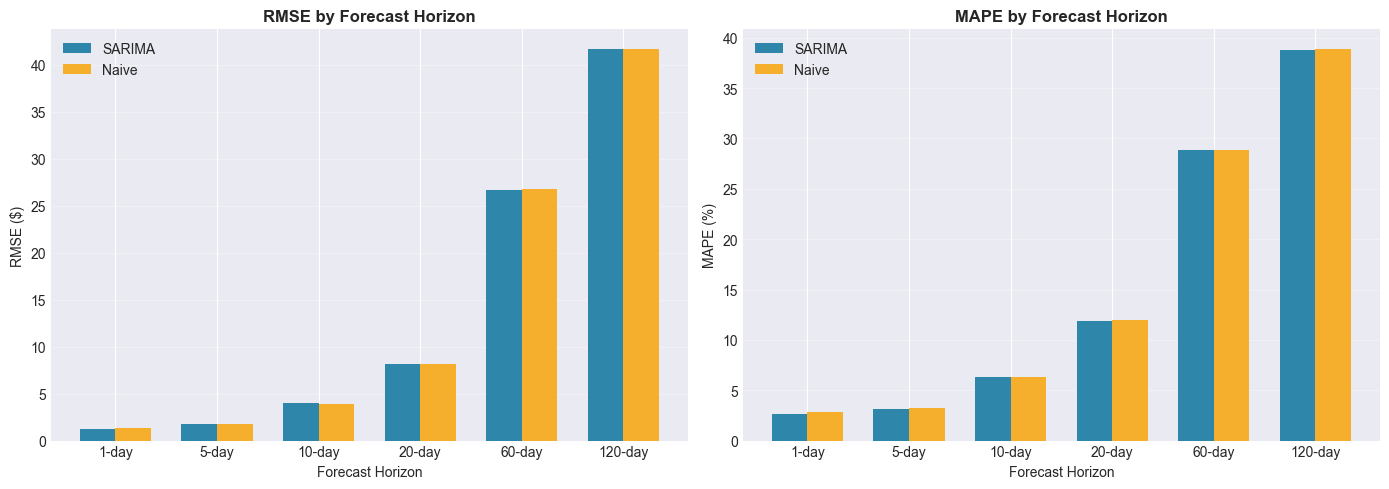


📌 Key Finding: Error increases with forecast horizon
📌 Short-term (1-5 days) forecasts are most reliable


In [46]:
# SHORT-TERM vs LONG-TERM COMPARISON
print("\n" + "="*70)
print("SHORT-TERM vs LONG-TERM FORECASTING")
print("="*70)
horizons = [1, 5, 10, 20, 60, 120]
horizon_results = []

for h in horizons:
    if h > len(test):
        continue
    
    # Multi-step SARIMA forecast
    sarima_h = sarima_final.forecast(steps=h)
    sarima_rmse = np.sqrt(mean_squared_error(test.iloc[:h], sarima_h))
    sarima_mape = mape(test.iloc[:h].values, sarima_h.values)
    
    # Naive forecast
    naive_h = [train_val.iloc[-1]] * h
    naive_rmse = np.sqrt(mean_squared_error(test.iloc[:h], naive_h))
    naive_mape = mape(test.iloc[:h].values, naive_h)
    
    horizon_results.append({
        'Horizon': f'{h}-day',
        'SARIMA_RMSE': round(sarima_rmse, 2),
        'SARIMA_MAPE%': round(sarima_mape, 2),
        'Naive_RMSE': round(naive_rmse, 2),
        'Naive_MAPE%': round(naive_mape, 2)
    })

horizon_df = pd.DataFrame(horizon_results)
print("\n📊 Forecast Performance by Horizon:")
print(horizon_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = range(len(horizon_results))
width = 0.35

# RMSE comparison
axes[0].bar([i - width/2 for i in x], [r['SARIMA_RMSE'] for r in horizon_results], 
            width, label='SARIMA', color='#2E86AB')
axes[0].bar([i + width/2 for i in x], [r['Naive_RMSE'] for r in horizon_results], 
            width, label='Naive', color='#F6AE2D')
axes[0].set_xlabel('Forecast Horizon')
axes[0].set_ylabel('RMSE ($)')
axes[0].set_title('RMSE by Forecast Horizon', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([r['Horizon'] for r in horizon_results])
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# MAPE comparison
axes[1].bar([i - width/2 for i in x], [r['SARIMA_MAPE%'] for r in horizon_results], 
            width, label='SARIMA', color='#2E86AB')
axes[1].bar([i + width/2 for i in x], [r['Naive_MAPE%'] for r in horizon_results], 
            width, label='Naive', color='#F6AE2D')
axes[1].set_xlabel('Forecast Horizon')
axes[1].set_ylabel('MAPE (%)')
axes[1].set_title('MAPE by Forecast Horizon', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels([r['Horizon'] for r in horizon_results])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('17_horizon_comparison.png', dpi=150)
plt.show()

print("\n📌 Key Finding: Error increases with forecast horizon")
print("📌 Short-term (1-5 days) forecasts are most reliable")


PART 18: FINAL MODEL COMPARISON


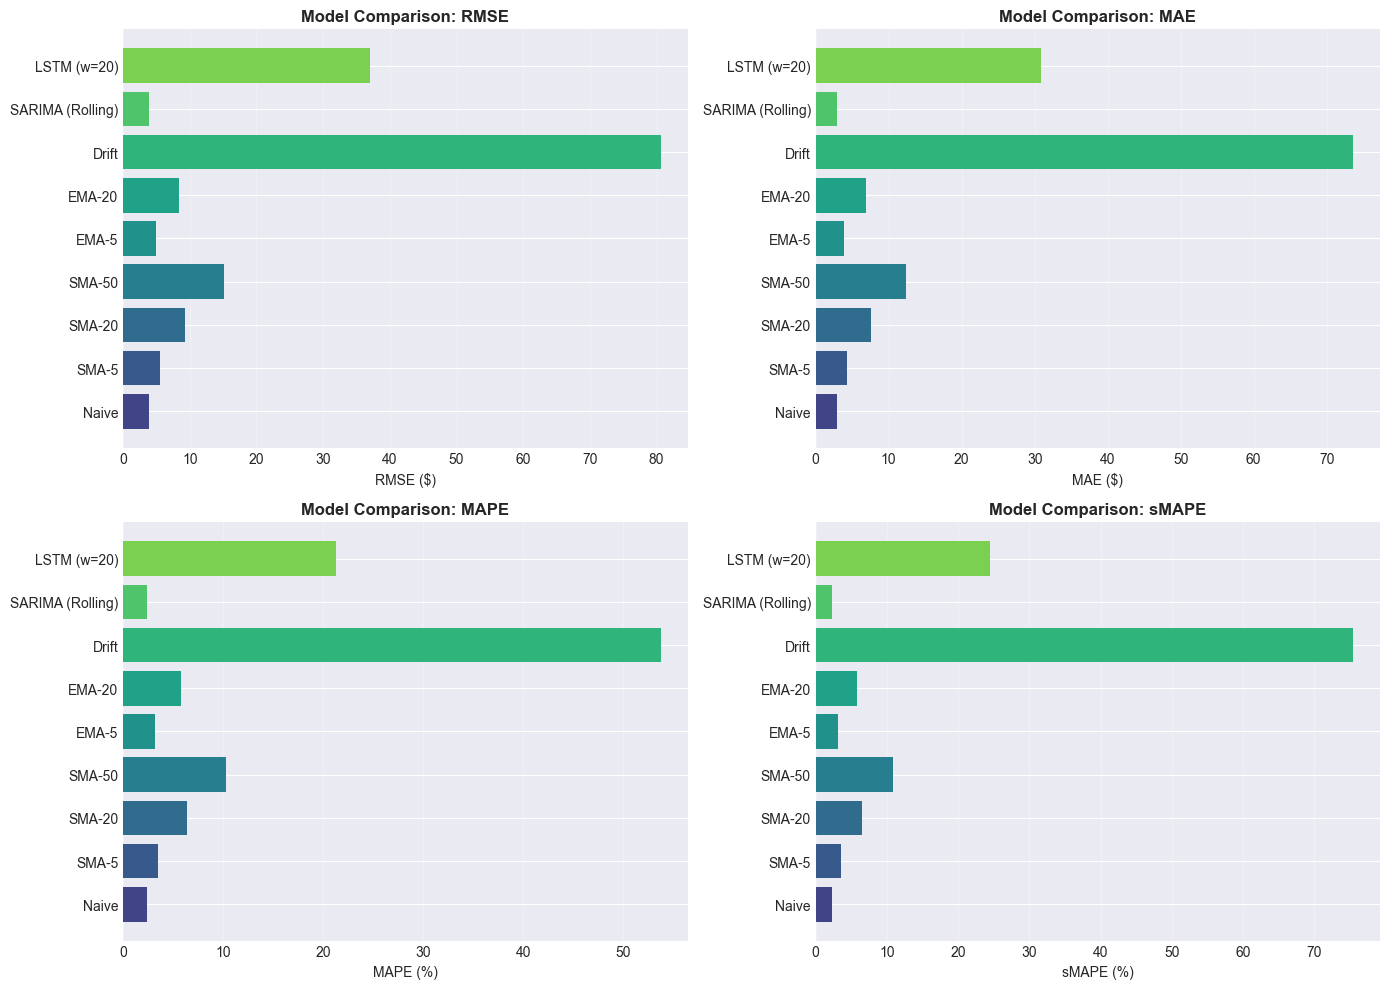

In [47]:
# FINAL MODEL COMPARISON


print("\n" + "="*70)
print("PART 18: FINAL MODEL COMPARISON")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models_list = test_df['model'].tolist()
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(models_list)))

# RMSE comparison
axes[0, 0].barh(models_list, test_df['RMSE'].tolist(), color=colors)
axes[0, 0].set_xlabel('RMSE ($)')
axes[0, 0].set_title('Model Comparison: RMSE', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# MAE comparison
axes[0, 1].barh(models_list, test_df['MAE'].tolist(), color=colors)
axes[0, 1].set_xlabel('MAE ($)')
axes[0, 1].set_title('Model Comparison: MAE', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# MAPE comparison
axes[1, 0].barh(models_list, test_df['MAPE'].tolist(), color=colors)
axes[1, 0].set_xlabel('MAPE (%)')
axes[1, 0].set_title('Model Comparison: MAPE', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# sMAPE comparison
axes[1, 1].barh(models_list, test_df['sMAPE'].tolist(), color=colors)
axes[1, 1].set_xlabel('sMAPE (%)')
axes[1, 1].set_title('Model Comparison: sMAPE', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('18_model_comparison.png', dpi=150)
plt.show()
